In [1]:
import sys
import os
import warnings
import numpy as np
import tensorflow as tf
import SimpleITK as sitk
from nilearn import image, plotting
import nibabel as nib
import matplotlib.pyplot as plt

sys.path.append("../")
sys.path.append("../deepneuroan")
sys.path.append('/home/ltetrel/DeepNeuroAN/deepneuroan/')
sys.path.append('/home/ltetrel/DeepNeuroAN/')
warnings.filterwarnings('ignore')

from deepneuroan.data_generator import DataGenerator
from deepneuroan.models import ChannelwiseConv3D, rigid_concatenated
import deepneuroan.utils as utils
from deepneuroan.preproc import create_ref_grid, get_mni152_affine_nib, get_mni152_affine_itk

Failed to import duecredit due to No module named 'duecredit'


In [2]:
data_dir = "/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/generated_data/"
template_filepath = os.path.join(data_dir, "template_on_grid")

list_files = []
list_files_tmp = set([])
for root, _, files in os.walk(data_dir):
    for file in files:
        filepath = os.path.join(root, file).split('.')[0]
        if os.path.exists(filepath + ".txt"):
            list_files_tmp.add(filepath)
list_files = list(list_files_tmp)

bs = 2
ncpu = 1
np.random.seed(0)
params_gen = dict(list_files=list_files, template_file=template_filepath, batch_size=bs, avail_cores=ncpu, is_unsupervised=True)
gen = DataGenerator(partition="all", **params_gen)

In [3]:
# with open("/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/rigid_concatenated_2020-01-17_22:26:33.json", "r") as json_file:
#     model = tf.keras.models.model_from_json(json_file.read(), custom_objects={'ChannelwiseConv3D': ChannelwiseConv3D})
# model.load_weights("/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/checkpoints/rigid_concatenated_best/rigid_concatenated_cp-0250.ckpt")
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss=tf.keras.losses.mean_squared_error, metrics=["mae"])

In [17]:
ref_grid = create_ref_grid()

# select which idx and batch to take
batch = 1
idx = 1

filename = gen.get_files_batch(idx)[batch] + ".txt"
print(filename)
fixed = gen.__getitem__(idx)[0][0][batch, :, :, :, 0]
moving = gen.__getitem__(idx)[0][1][batch, :, :, :, 0]
mini = np.min(moving)
moving_sitk = sitk.GetImageFromArray(moving)
moving_sitk.SetOrigin(ref_grid.GetOrigin())
moving_sitk.SetSpacing(ref_grid.GetSpacing())
moving_sitk.SetDirection(ref_grid.GetDirection())

# moving = sitk.ReadImage(valid_gen.get_target_files_batch(0)[batch] + ".nii.gz", sitk.sitkFloat32)
# fixed = sitk.ReadImage(valid_gen.get_files_batch(0)[batch] + ".nii.gz", sitk.sitkFloat32)
# t_rigid = model.predict(x=valid_gen.__getitem__(0)[0], use_multiprocessing=False, verbose=0)[batch,]
# t_rigid = valid_gen.__getitem__(0)[1][batch,]
t_rigid = utils.load_trf_file(filename)
t_rigid_inv = (-1)*np.copy(t_rigid)
q_norm = t_rigid[0]**2 + t_rigid[1]**2 + t_rigid[2]**2 + t_rigid[3]**2
t_rigid_inv[0] = t_rigid[0]/q_norm
t_rigid_inv[1] = (-1)*t_rigid[1]/q_norm
t_rigid_inv[2] = (-1)*t_rigid[2]/q_norm
t_rigid_inv[3] = (-1)*t_rigid[3]/q_norm
print(t_rigid_inv)

registered_moving = utils.transform_volume(moving_sitk, ref_grid, interp=sitk.sitkBSplineResampler, rigid=t_rigid_inv)
pred_mask = sitk.GetArrayFromImage(registered_moving) > 0
truth_mask = fixed > 0
# for i in range(all_gen.__len__()):
#     fixed = valid_gen.__getitem__(0)[0][:, :, :, :,0]
#     moving = valid_gen.__getitem__(0)[0][:, :, :, :,1]
#     for batch in range(valid_gen.batch_size):
#         sitk.GetImageFromArray(valid_gen.__getitem__(0)[0][:, :, :, :,0])
#         pred = sitk.Image(ref_grid.GetSize(), ref_grid.GetPixelIDValue())
#         pred.SetOrigin(ref_grid.GetOrigin())
#         pred.SetSpacing(ref_grid.GetSpacing())
#         pred.SetDirection(ref_grid.GetDirection())

/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/generated_data/ses-vid001_task-video_run-01_bold_vol-0157_transfo-000001.txt
[ 0.96031959  0.13069008  0.22782914  0.09381306 -0.          0.
  0.        ]


In [12]:
# sitk.WriteImage(registered_moving, "registered_moving.nii.gz")
# sitk.WriteImage(sitk.ReadImage(valid_gen.get_files_batch(0)[batch] + ".nii.gz", sitk.sitkFloat32), "fixed.nii.gz")

In [13]:
# def dice_loss(y_true, y_pred):
  
#     num = 2 * tf.reduce_sum(y_true * y_pred, -1)
#     den = tf.maximum(tf.reduce_sum(y_true + y_pred, -1), 1e-6)

#     return -tf.reduce_mean(num/den)

def dice_loss(y_true, y_pred):
    
    true_masked = tf.clip_by_value(y_true*1e9, 0, 1)
    pred_masked = tf.clip_by_value(y_pred*1e9, 0, 1)

    numerator = 2 * tf.reduce_sum(true_masked * pred_masked)
    denominator = tf.reduce_sum(true_masked) + tf.reduce_sum(pred_masked)    
    return (numerator + 1) / (denominator + 1)

def dice_loss_mask(y_true, y_pred):
  
    numerator = 2 * np.sum(y_true * y_pred)
    denominator = np.sum(y_true) + np.sum(y_pred)    
    return (numerator + 1) / (denominator + 1)

print(dice_loss_mask(truth_mask, pred_mask))
print(dice_loss(fixed, sitk.GetArrayFromImage(registered_moving)))

0.8001566184627023
tf.Tensor(0.8001566, shape=(), dtype=float32)


In [14]:
def ncc(I, J):
    mean_I = tf.reduce_mean(I)
    mean_J = tf.reduce_mean(J)
    IJ_cross = tf.reduce_sum((I - mean_I)*(J - mean_J))
    IJ_norm = tf.sqrt(tf.reduce_sum(tf.pow(I - mean_I, 2))) * tf.sqrt(tf.reduce_sum(tf.pow(J - mean_J, 2)))
    ncc = IJ_cross / IJ_norm
    
    return (-1)*ncc
    
fixed_tf = tf.convert_to_tensor(fixed)
fixed_tf = tf.expand_dims(fixed_tf, axis=0)
fixed_tf = tf.expand_dims(fixed_tf, axis=-1)
moving_tf = tf.convert_to_tensor(sitk.GetArrayFromImage(registered_moving))
moving_tf = tf.expand_dims(moving_tf, axis=0)
moving_tf = tf.expand_dims(moving_tf, axis=-1)

ncc(fixed_tf, moving_tf)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.7575221>

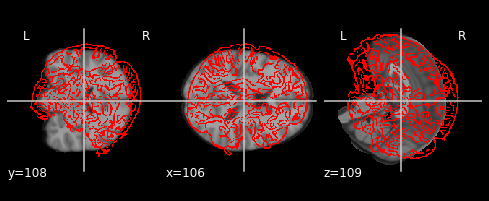

In [15]:
background = nib.Nifti1Image(fixed, np.eye(4))
edges = nib.Nifti1Image(sitk.GetArrayFromImage(registered_moving), np.eye(4))

display = plotting.plot_anat(background)
display.add_edges(edges)

def generate_png(scan,nslices=20):
    from nilearn import plotting
    import os
    nifti_filename = os.path.basename(scan)
    nifti_filename_noext = os.path.splitext(os.path.splitext(nifti_filename)[0])[0]
    workfolder = os.getcwd()
    imagefile1 = f"{workfolder}/{nifti_filename_noext}.png"
    plotting.plot_anat(scan, display_mode='ortho', annotate=True, output_file=imagefile1)
    imagefile2 = f"{workfolder}/{nifti_filename_noext}_slices.png"
    plotting.plot_anat(scan, display_mode='y', cut_coords=nslices, annotate=True, output_file=imagefile2)
    return imagefile1

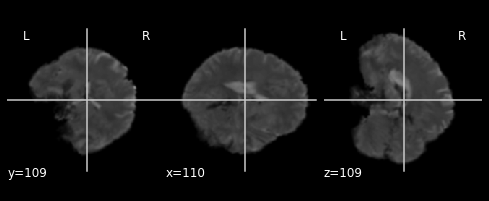

In [16]:
background = nib.Nifti1Image(moving, np.eye(4))
display = plotting.plot_anat(background)

In [ ]:
from PIL import Image

def make_image(tensor):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    height, width, channel = tensor.shape
    print(tensor.shape)
    image = Image.fromarray(tensor.numpy().astype(np.uint8))
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    print(image_string)
    img = tf.reshape(img, (-1, 28, 28, 1))
    return tf.summary.image("Training data", img)
tf_arr = tf.ones((10, 10))
make_image(tf_arr)

In [ ]:
nib_img = nib.load("/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/generated_data/ses-vid001_task-video_run-01_bold_vol-0127.nii.gz")
print(nib_img.get_affine()
itk_img = sitk.ReadImage("/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/generated_data/ses-vid001_task-video_run-01_bold_vol-0127.nii.gz")
print(itk_img.GetDirection())
print(itk_img.GetSpacing())
print(itk_img.GetOrigin())
print(itk_img.GetSize())

In [ ]:
itk_tmp = sitk.GetImageFromArray(itk_data)
itk_tmp.SetDirection(get_mni152_affine_itk()[:3, :3].flatten())
itk_tmp.SetSpacing((1., 1., 1.))
itk_tmp.SetOrigin(get_mni152_affine_itk()[:3,3])
sitk.WriteImage(itk_tmp, "itk_tmp.nii.gz")

nib_tmp = sitk.GetImageFromArray(nib_data)
# nib_tmp.SetDirection(get_mni152_affine_nib()[:3, :3].flatten())
nib_tmp.SetSpacing((1., 1., 1.))
nib_tmp.SetOrigin(get_mni152_affine_nib()[:3,3])
sitk.WriteImage(nib_tmp, "nib_tmp.nii.gz")

In [ ]:
nib_data = nib_img.get_data()
itk_data = sitk.GetArrayFromImage(itk_img)
# recreated_sitk = sitk.GetImageFromArray(nib_data)
# recreated_sitk.SetOrigin(ref_grid.GetOrigin())
# recreated_sitk.SetSpacing(ref_grid.GetSpacing())
# recreated_sitk.SetDirection(ref_grid.GetDirection())
# itk_data = sitk.GetArrayFromImage(recreated_sitk)
mask = nib_data != itk_data
print(np.sum(mask)/(nib_data.shape[0] * nib_data.shape[1] * nib_data.shape[2]))